## Quantization-Aware Dense Network for MNIST Classification

### Network Structure

1. **Input Layer**: 
   - Shape: (28, 28, 1) 

2. **Flatten Layer**: 
   - Converts the 2D input image into a 1D array of 784 elements.

3. **Quantized Dense Layer 1**: 
   - Units: 128 
   - Activation: ReLU 
   - This layer uses the custom `LearnedQuantizedDense`.

4. **Quantized Dense Layer 2**: 
   - Units: 10 
   - Activation: Softmax 
   - This layer also uses `LearnedQuantizedDense`.

### LearnedQuantizedDense Layer

The `LearnedQuantizedDense` layer performs the following operations:

1. **Weights and Biases Initialization**: 
   - Weights `w` and biases `b` are initialized with a normal distribution as learnable parameters.
   - `scale` and `zero_point` are also initialized with a normal distribution as learnable parameters.

2. **Quantization Process**:
   - The weights are quantized using the formula:
     
     ```
     quantized_w = round(w / scale + zero_point)
     ```

     > Here, `scale` and `zero_point` are learned parameters.

   - This operation is made differentiable by using the `tf.stop_gradient` function, which stops the gradient flow during backpropagation for the rounding operation, but retains the original value for forward propagation.

3. **Dequantization**:
   - The quantized weights are then dequantized to approximate the original weights:
   
     ```
     dequantized_w = (quantized_w - zero_point) * scale
     ```

4. **Output Calculation**:
   - The layer output is calculated using the dequantized weights and biases:
     ```
     output = inputs * dequantized_w + dequantized_b
     ```

In [56]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        print(input_shape, self.units)
        self.w = self.add_weight(           shape=(input_shape[-1], self.units), 
                                            initializer="random_normal",
                                            trainable=True)
        self.b = self.add_weight(           shape=(self.units,), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.scale = self.add_weight(       shape=(input_shape[-1], 1), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.zero_point = self.add_weight(  shape=(input_shape[-1], 1), 
                                            initializer="random_normal",
                                            trainable=True)

    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale + self.zero_point)) + \
                    (self.w / self.scale + self.zero_point - tf.stop_gradient(self.w / self.scale + self.zero_point))
        dequantized_w = (quantized_w - self.zero_point) * self.scale
        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0] + self.zero_point[0, 0])) + \
                    (self.b / self.scale[0, 0] + self.zero_point[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0] + self.zero_point[0, 0]))
        dequantized_b = (quantized_b - self.zero_point[0, 0]) * self.scale[0, 0]

        output = tf.matmul(inputs, dequantized_w) + dequantized_b
        if self.activation is not None:
            output = self.activation(output)
        return output


input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(quantized_dense_layer)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
# Please look into the loss function
# Conceptually we need to inspure the network to learn what we actually want them to learn
# in the loss function -> it should incroporate the penalty (1. number of distinct values) (2. **scale**, zero point -> continuous) (3. maybe both)
# Play around with the different loss functions
# Sebastian: modifications in the networks (the gradients), but not the loss functions primarily? (scales to loss function??)
# Both, the network + the loss function should include them
quantized_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

quantized_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

(None, 784) 128


(None, 128) 10
Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2293 - accuracy: 0.8705 - val_loss: 0.3838 - val_accuracy: 0.9038
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2738 - accuracy: 0.9289 - val_loss: 0.2621 - val_accuracy: 0.9350
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2460 - accuracy: 0.9388 - val_loss: 0.2654 - val_accuracy: 0.9387
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2365 - accuracy: 0.9429 - val_loss: 0.3108 - val_accuracy: 0.9337
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2276 - accuracy: 0.9470 - val_loss: 0.3034 - val_accuracy: 0.9363
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2151 - accuracy: 0.9509 - val_loss: 0.2657 - val_accuracy: 0.9451
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1986 - accuracy: 0.9547 - val_loss: 0.2695 

KeyboardInterrupt: 

(None, 784) 128
(None, 128) 10
TOTAL SCALES:  784
Selected indices for scale tracking: [649 726  47 663 283  26 629  40 706 566]
Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3799 - accuracy: 0.8713 - val_loss: 0.3108 - val_accuracy: 0.9195
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2618 - accuracy: 0.9316 - val_loss: 0.2826 - val_accuracy: 0.9267
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2474 - accuracy: 0.9381 - val_loss: 0.2705 - val_accuracy: 0.9400
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2334 - accuracy: 0.9453 - val_loss: 0.2476 - val_accuracy: 0.9462
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2197 - accuracy: 0.9472 - val_loss: 0.2680 - val_accuracy: 0.9452
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2101 - accuracy: 0.9521 - val_loss: 0.3179 - val_accuracy: 0.9414
Epoch 7

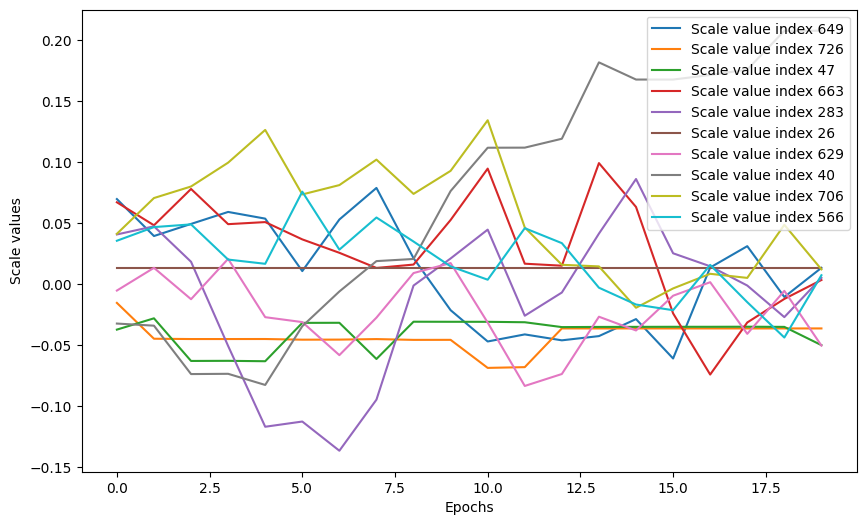

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1) # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)


class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        print(input_shape, self.units)
        self.w = self.add_weight(           shape=(input_shape[-1], self.units), 
                                            initializer="random_normal",
                                            trainable=True)
        self.b = self.add_weight(           shape=(self.units,), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.scale = self.add_weight(       shape=(input_shape[-1], 1), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.zero_point = self.add_weight(  shape=(input_shape[-1], 1), 
                                            initializer="random_normal",
                                            trainable=True)

    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale + self.zero_point)) + \
                      (self.w / self.scale + self.zero_point - tf.stop_gradient(self.w / self.scale + self.zero_point))
        dequantized_w = (quantized_w - self.zero_point) * self.scale
        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0] + self.zero_point[0, 0])) + \
                      (self.b / self.scale[0, 0] + self.zero_point[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0] + self.zero_point[0, 0]))
        dequantized_b = (quantized_b - self.zero_point[0, 0]) * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b
        if self.activation is not None:
            output = self.activation(output)
        return output

class ScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer, num_scales=10):
        super(ScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.num_scales = num_scales
        self.scale_values = []
        self.selected_indices = None

    def on_train_begin(self, logs=None):
        # Randomly select `num_scales` indices to track
        total_scales = self.layer.scale.shape[0]
        print("TOTAL SCALES: ", total_scales)
        self.selected_indices = np.random.choice(total_scales, self.num_scales, replace=False)
        print(f"Selected indices for scale tracking: {self.selected_indices}")

    def on_epoch_end(self, epoch, logs=None):
        # Track the selected scale values
        scale_value = self.layer.scale.numpy()[self.selected_indices]
        self.scale_values.append(scale_value)
        #print(f"Epoch {epoch+1}: Scale values: {scale_value}")

    def plot_scale_values(self):
        plt.figure(figsize=(10, 6))
        for i, idx in enumerate(self.selected_indices):
            scale_history = [epoch[i, 0] for epoch in self.scale_values]
            plt.plot(scale_history, label=f'Scale value index {idx}')
        plt.xlabel('Epochs')
        plt.ylabel('Scale values')
        plt.legend()
        plt.show()

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
quantized_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create the callback
scale_tracking_callback = ScaleTrackingCallback(quantized_dense_layer, num_scales=10)

quantized_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[scale_tracking_callback])
loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Plot the scale values
scale_tracking_callback.plot_scale_values()



(None, 784) 128
(None, 128) 10
Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1382 - accuracy: 0.8753 - val_loss: 0.2876 - val_accuracy: 0.9219
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2695 - accuracy: 0.9300 - val_loss: 0.2758 - val_accuracy: 0.9247
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2448 - accuracy: 0.9378 - val_loss: 0.2386 - val_accuracy: 0.9461
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2415 - accuracy: 0.9430 - val_loss: 0.2330 - val_accuracy: 0.9416
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2202 - accuracy: 0.9491 - val_loss: 0.2526 - val_accuracy: 0.9506
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2050 - accuracy: 0.9510 - val_loss: 0.2708 - val_accuracy: 0.9442
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2059 - accuracy: 0.9521 - v

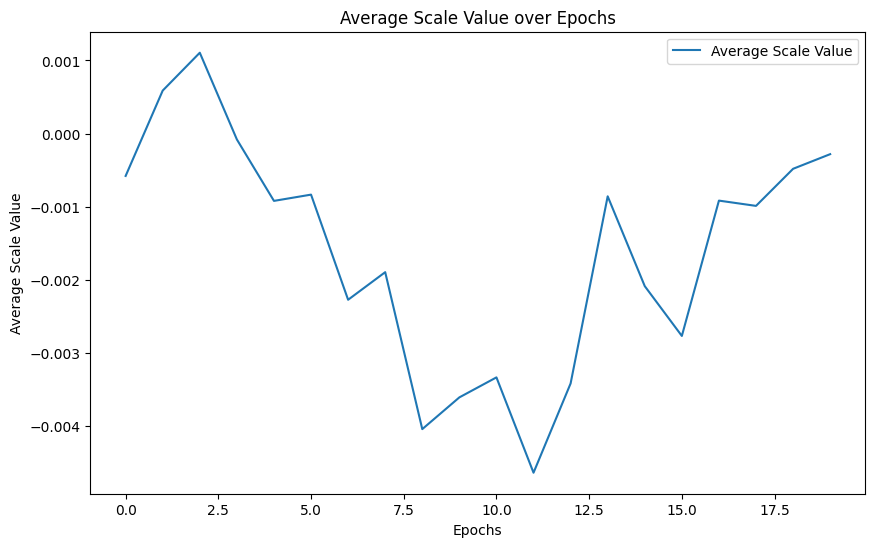

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1) # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)


class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        print(input_shape, self.units)
        self.w = self.add_weight(           shape=(input_shape[-1], self.units), 
                                            initializer="random_normal",
                                            trainable=True)
        self.b = self.add_weight(           shape=(self.units,), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.scale = self.add_weight(       shape=(input_shape[-1], 1), 
#                                            initializer=tf.random_uniform_initializer(minval=1, maxval=10), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.zero_point = self.add_weight(  shape=(input_shape[-1], 1), 
                                            initializer="random_normal",
                                            trainable=True)


    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale + self.zero_point)) + \
                      (self.w / self.scale + self.zero_point - tf.stop_gradient(self.w / self.scale + self.zero_point))
        dequantized_w = (quantized_w - self.zero_point) * self.scale
        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0] + self.zero_point[0, 0])) + \
                      (self.b / self.scale[0, 0] + self.zero_point[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0] + self.zero_point[0, 0]))
        dequantized_b = (quantized_b - self.zero_point[0, 0]) * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b
        if self.activation is not None:
            output = self.activation(output)
        return output

class AverageScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(AverageScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.average_scale_values = []

    def on_epoch_end(self, epoch, logs=None):
        scale_value = np.mean(self.layer.scale.numpy())
        self.average_scale_values.append(scale_value)
        print(f"Epoch {epoch+1}: Average scale value: {scale_value}")

    def plot_average_scale_values(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.average_scale_values, label='Average Scale Value')
        plt.xlabel('Epochs')
        plt.ylabel('Average Scale Value')
        plt.title('Average Scale Value over Epochs')
        plt.legend()
        plt.show()

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
quantized_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create the callback
average_scale_tracking_callback = AverageScaleTrackingCallback(quantized_dense_layer)

quantized_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[average_scale_tracking_callback])
loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Plot the average scale values
average_scale_tracking_callback.plot_average_scale_values()


(None, 784) 128
(None, 128) 10
Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 7.6882 - accuracy: 0.3361 - val_loss: 2.8752 - val_accuracy: 0.4503
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 96.3439 - accuracy: 0.5889 - val_loss: 11.4977 - val_accuracy: 0.7824
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 26.2128 - accuracy: 0.7164 - val_loss: 9.3752 - val_accuracy: 0.6921
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 243.7444 - accuracy: 0.7071 - val_loss: 43.3310 - val_accuracy: 0.8423
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 35.5540 - accuracy: 0.8401 - val_loss: 18.4270 - val_accuracy: 0.8711
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 119.7659 - accuracy: 0.8022 - val_loss: 276.3288 - val_accuracy: 0.7346
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 43.6366 - accurac

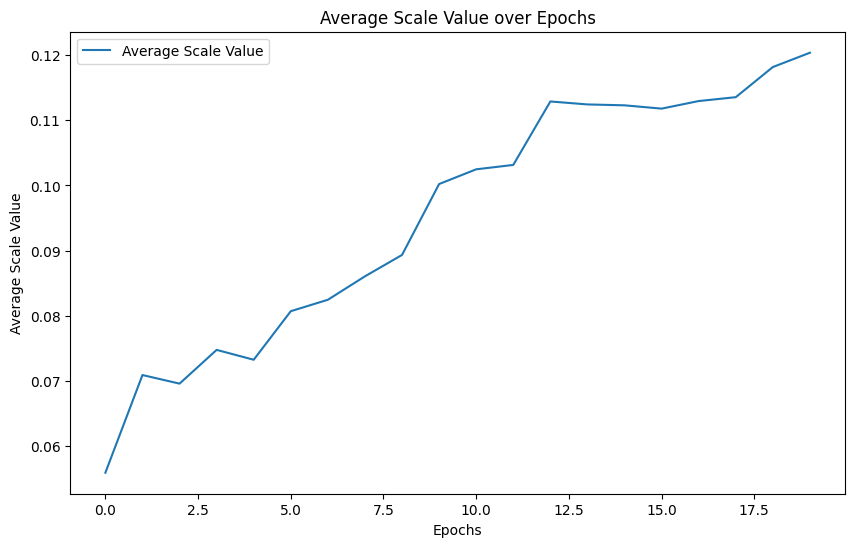

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1) # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)


class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        print(input_shape, self.units)
        self.w = self.add_weight(           shape=(input_shape[-1], self.units), 
                                            initializer="random_normal",
                                            trainable=True)
        self.b = self.add_weight(           shape=(self.units,), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.scale = self.add_weight(       shape=(input_shape[-1], 1), 
                                            initializer=tf.random_uniform_initializer(minval=-5, maxval=5), 
#                                            initializer="random_normal", 
                                            trainable=True)
        self.zero_point = self.add_weight(  shape=(input_shape[-1], 1), 
                                            initializer="random_normal",
                                            trainable=True)


    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale + self.zero_point)) + \
                      (self.w / self.scale + self.zero_point - tf.stop_gradient(self.w / self.scale + self.zero_point))
        dequantized_w = (quantized_w - self.zero_point) * self.scale
        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0] + self.zero_point[0, 0])) + \
                      (self.b / self.scale[0, 0] + self.zero_point[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0] + self.zero_point[0, 0]))
        dequantized_b = (quantized_b - self.zero_point[0, 0]) * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b
        if self.activation is not None:
            output = self.activation(output)
        return output

class AverageScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(AverageScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.average_scale_values = []

    def on_epoch_end(self, epoch, logs=None):
        scale_value = np.mean(self.layer.scale.numpy())
        self.average_scale_values.append(scale_value)
        print(f"Epoch {epoch+1}: Average scale value: {scale_value}")

    def plot_average_scale_values(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.average_scale_values, label='Average Scale Value')
        plt.xlabel('Epochs')
        plt.ylabel('Average Scale Value')
        plt.title('Average Scale Value over Epochs')
        plt.legend()
        plt.show()

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
quantized_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create the callback
average_scale_tracking_callback = AverageScaleTrackingCallback(quantized_dense_layer)

quantized_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[average_scale_tracking_callback])
loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Plot the average scale values
average_scale_tracking_callback.plot_average_scale_values()
